In [1]:
import geopandas as gpd
from glob import glob
import os
from matplotlib import pyplot as plt


In [2]:
eco_shp = '../na_cec_eco_l1/NA_CEC_Eco_Level1.shp'
df_eco = gpd.read_file(eco_shp)

In [4]:
df_eco.head()

,NA_L1CODE,NA_L1NAME,NA_L1KEY,Shape_Leng,Shape_Area,geometry
0,0,WATER,0 WATER,2.213011e+05,1.101377e+09,"POLYGON ((-323157.7511 -2716207.7489, -323047...."
1,0,WATER,0 WATER,1.483641e+07,2.461369e+11,"POLYGON ((871899.6886999998 506114.7168000005,..."
2,1,ARCTIC CORDILLERA,1 ARCTIC CORDILLERA,1.891064e+04,2.093145e+07,"POLYGON ((2127802.5041 1983376.497099999, 2127..."
3,1,ARCTIC CORDILLERA,1 ARCTIC CORDILLERA,1.869981e+04,2.418667e+07,"POLYGON ((2053940.7532 2010341.128699999, 2053..."
4,1,ARCTIC CORDILLERA,1 ARCTIC CORDILLERA,1.979422e+04,2.643824e+07,"POLYGON ((2068507.8741 2028919.872, 2069439.00..."


In [5]:
df_eco.NA_L1NAME.unique()

array(['WATER', 'ARCTIC CORDILLERA', 'NORTH AMERICAN DESERTS',
       'MEDITERRANEAN CALIFORNIA', 'SOUTHERN SEMIARID HIGHLANDS',
       'TEMPERATE SIERRAS', 'TROPICAL DRY FORESTS',
       'TROPICAL WET FORESTS', 'TUNDRA', 'TAIGA', 'HUDSON PLAIN',
       'NORTHERN FORESTS', 'NORTHWESTERN FORESTED MOUNTAINS',
       'MARINE WEST COAST FOREST', 'EASTERN TEMPERATE FORESTS',
       'GREAT PLAINS'], dtype=object)

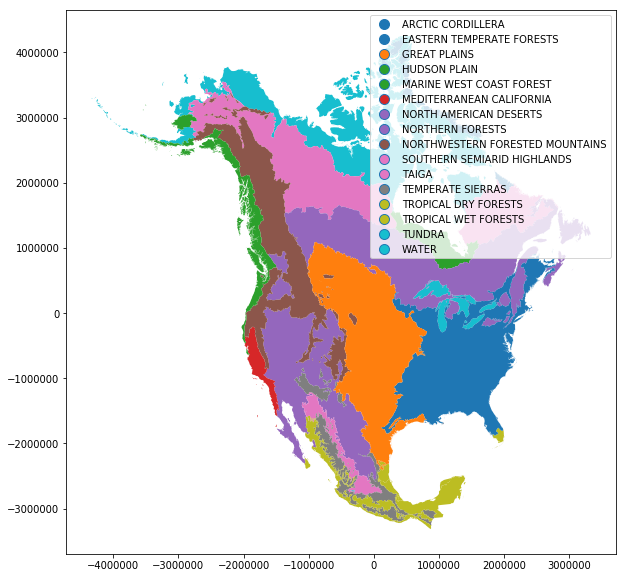

In [13]:
df_eco.plot(column="NA_L1NAME", figsize=(10,10), legend=True)

In [34]:
us_boundary = gpd.read_file('../CONUS_boundary/CONUS_boundary.shp')

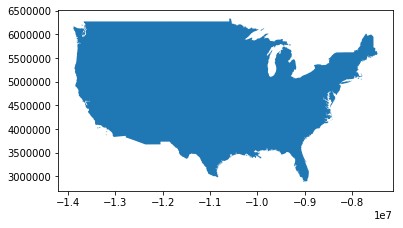

In [36]:
us_boundary.plot()

In [40]:
us_boundary.crs, df_eco.crs

({'init': 'epsg:3857'},
 {'a': 6370997,
  'b': 6370997,
  'lat_0': 45,
  'lon_0': -100,
  'no_defs': True,
  'proj': 'laea',
  'units': 'm',
  'x_0': 0,
  'y_0': 0})

In [41]:
from earthpy.clip import clip_shp

In [53]:
test = clip_shp(df_eco.to_crs(epsg=3857), us_boundary).reset_index()

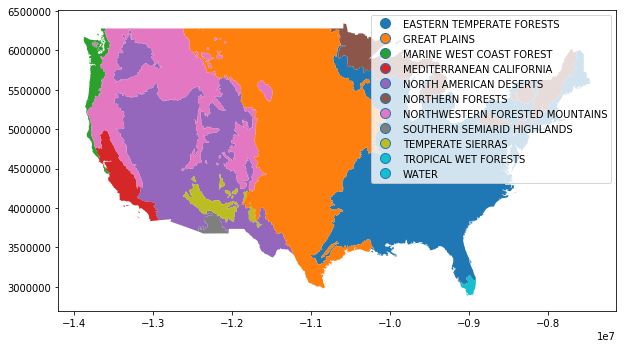

In [54]:
test.plot(column="NA_L1NAME", figsize=(10,10), legend=True)

In [55]:
test.NA_L1NAME.unique().shape

(11,)

In [58]:
test_name = test.NA_L1NAME[0]
test_name.replace(' ', '_')

'EASTERN_TEMPERATE_FORESTS'

In [61]:
groups = test.groupby('NA_L1NAME')
for group in groups:
    print(group[0], group[1].head())

EASTERN TEMPERATE FORESTS    index NA_L1CODE                  NA_L1NAME                      NA_L1KEY  \
0   2002         8  EASTERN TEMPERATE FORESTS  8  EASTERN TEMPERATE FORESTS   
1   2014         8  EASTERN TEMPERATE FORESTS  8  EASTERN TEMPERATE FORESTS   
2   2015         8  EASTERN TEMPERATE FORESTS  8  EASTERN TEMPERATE FORESTS   
3   2019         8  EASTERN TEMPERATE FORESTS  8  EASTERN TEMPERATE FORESTS   
4   2028         8  EASTERN TEMPERATE FORESTS  8  EASTERN TEMPERATE FORESTS   

      Shape_Leng    Shape_Area  \
0    2293.192372  3.374335e+05   
1   33292.842298  7.308003e+06   
2    6874.214627  7.997862e+05   
3  101816.915189  2.537028e+07   
4   15708.177112  2.841671e+06   

                                            geometry  
0  POLYGON ((-7818493.630414151 5417164.019218392...  
1  POLYGON ((-7786599.018038419 5432578.144002809...  
2  (POLYGON ((-7783035.451414463 5432482.60428471...  
3  (POLYGON ((-7780295.298771944 5443353.24114592...  
4  POLYGON ((-77420

352  4.358625e+08  POLYGON ((-11992598.97965643 4160544.447462176...  
TROPICAL WET FORESTS      index NA_L1CODE             NA_L1NAME                  NA_L1KEY  \
74     256        15  TROPICAL WET FORESTS  15  TROPICAL WET FORESTS   
75     288        15  TROPICAL WET FORESTS  15  TROPICAL WET FORESTS   
139    243        15  TROPICAL WET FORESTS  15  TROPICAL WET FORESTS   
140    242        15  TROPICAL WET FORESTS  15  TROPICAL WET FORESTS   
141    247        15  TROPICAL WET FORESTS  15  TROPICAL WET FORESTS   

       Shape_Leng    Shape_Area  \
74   5.274842e+04  4.574824e+07   
75   1.827217e+06  2.216951e+10   
139  7.746816e+04  1.774046e+07   
140  1.821775e+04  3.976483e+06   
141  1.498133e+04  4.085823e+06   

                                              geometry  
74   POLYGON ((-9096143.064749815 2994323.71224287,...  
75   (POLYGON ((-8936463.367329873 3081829.57810697...  
139  POLYGON ((-9020491.563202361 2904225.49383055,...  
140  POLYGON ((-9022098.915193487 29

In [63]:
from helpers import clip_points_by_ecoregion
from glob import glob
import multiprocessing as mp
from functools import partial


PyTables is not installed. No support for HDF output.


In [ ]:
output_folder = '../epa_L1_ecoregion_points'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
fire_pts_folders = !ls -d ../modis_fire_points/*
shp_files = [glob(folder + '/*.shp')[0] for folder in fire_pts_folders]

## group the ecoregions by name
groups = test.groupby('NA_L1NAME')

num_cpu = mp.cpu_count() - 2
num_cpu = 3
pool = mp.Pool(processes=num_cpu)

for group in groups:
    a = pool.map(partial(clip_points_by_ecoregion, group=group, out_folder=output_folder), shp_files)

pool.close()
pool.join()